# YOLO를 이용한 뇌종양 객체 인식

## 0. 라이브러리

In [2]:
import os, shutil, random

import pandas as pd
import numpy as np

import cv2
import PIL
from PIL import Image, ImageDraw, ImageFont

from sklearn.model_selection import train_test_split
import albumentations as albu # augmentation

from ultralytics import YOLO

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

## 1. 데이터

* https://www.kaggle.com/datasets/davidbroberts/brain-tumor-object-detection-datasets
* 뇌종양 탐지를 위한 MRI 이미지에 포함된 bounding box 좌표이며, 데이터셋의 JPG 파일들은 원본 크기로 축 (Axial, Coronal, Sagittal) 에 따라서 나뉘어져 있습니다.
* 종양은 https://makesense.ai 를 사용하여 수작업으로 라벨링되었고, RSNA-MICCAI 경진대회 데이터에서 T1wCE 시리즈의 축 별로 0~400개의 이미지에 bounding box 좌표와 MGMT positive 라벨이 표시되어 있습니다.
* 여기서는 Axial 데이터를 사용하여 객체인식을 수행합니다.

### 1) 다운로드/로드

In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download('davidbroberts/brain-tumor-object-detection-datasets')

# print('Path to dataset files:', path)

#### 재구성

In [ ]:
# DATASET_DIR = './dataset/brain_tumor'

# TRAIN_DIR = DATASET_DIR+'/total/train'
# TEST_DIR = DATASET_DIR+'/total/test'
# VAL_DIR = DATASET_DIR+'/total/val'

In [ ]:
# os.mkdir(DATASET_DIR+'/total')

# # Train
# os.mkdir(TRAIN_DIR)
# os.mkdir(TRAIN_DIR+'/images')
# os.mkdir(TRAIN_DIR+'/labels')

# # Test
# os.mkdir(TEST_DIR)
# os.mkdir(TEST_DIR+'/images')
# os.mkdir(TEST_DIR+'/labels')

# # Validation
# os.mkdir(VAL_DIR)
# os.mkdir(VAL_DIR+'/images')
# os.mkdir(VAL_DIR+'/labels')

In [ ]:
# # 파일 복사
# shutil.copytree(os.path.join(DATASET_DIR, 'images/train'), os.path.join(TRAIN_DIR, 'images'), dirs_exist_ok=True)
# shutil.copytree(os.path.join(DATASET_DIR, 'labels/train'), os.path.join(TRAIN_DIR, 'labels'), dirs_exist_ok=True)
# shutil.copytree(os.path.join(DATASET_DIR, 'images/test'), os.path.join(TEST_DIR, 'images'), dirs_exist_ok=True)
# shutil.copytree(os.path.join(DATASET_DIR, 'labels/test'), os.path.join(TEST_DIR, 'labels'), dirs_exist_ok=True)

'./dataset/brain_tumor/total/test\\labels'

In [ ]:
# # 파일 개수 비교
# def count_files(folder):
#     return len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])

# def compare_folders(src_folder, dest_folder):
#     src_count = count_files(src_folder)
#     dest_count = count_files(dest_folder)

#     if src_count==dest_count:
#         print(f'{src_folder} → {dest_folder}: 파일 개수 동일 ({src_count}개)')
#     else:
#         print(f'{src_folder} → {dest_folder}: 파일 개수 불일치! (원본: {src_count}개, 복사본: {dest_count}개)')

# compare_folders(os.path.join(DATASET_DIR, 'images/train'), os.path.join(TRAIN_DIR, 'images'))
# compare_folders(os.path.join(DATASET_DIR, 'labels/train'), os.path.join(TRAIN_DIR, 'labels'))
# compare_folders(os.path.join(DATASET_DIR, 'images/test'), os.path.join(TEST_DIR, 'images'))
# compare_folders(os.path.join(DATASET_DIR, 'labels/test'), os.path.join(TEST_DIR, 'labels'))

./dataset/brain_tumor\images/train → ./dataset/brain_tumor/total/train\images: 파일 개수 동일 (310개)
./dataset/brain_tumor\labels/train → ./dataset/brain_tumor/total/train\labels: 파일 개수 동일 (296개)
./dataset/brain_tumor\images/test → ./dataset/brain_tumor/total/test\images: 파일 개수 동일 (75개)
./dataset/brain_tumor\labels/test → ./dataset/brain_tumor/total/test\labels: 파일 개수 동일 (75개)


In [ ]:
# # 라벨 없는 이미지 삭제
# def remove_images_without_labels(folder_dir):
#     images_folder = os.path.join(folder_dir, 'images')
#     labels_folder = os.path.join(folder_dir, 'labels')

#     images = os.listdir(images_folder)
#     labels = os.listdir(labels_folder)

#     images_without_labels = set(images)-set([os.path.splitext(label)[0] + '.jpg' for label in labels])

#     for image in images_without_labels:
#         image_path = os.path.join(images_folder, image)
#         os.remove(image_path)

#     print(f'{len(images_without_labels)} 개의 라벨이 없는 이미지가 제거되었습니다.')

In [ ]:
# remove_images_without_labels(TRAIN_DIR)

14 개의 라벨이 없는 이미지가 제거되었습니다.


#### 검증 데이터셋 만들기

* 학습 데이터셋에서 20% 분리

In [ ]:
# def create_validation_set(train_dir, val_dir, split_ratio=0.2):

#     labels_dir = os.path.join(train_dir, 'labels')
#     images_dir = os.path.join(train_dir, 'images')

#     label_files = os.listdir(labels_dir)
#     num_files_to_move = int(len(label_files)*split_ratio)
#     files_to_move = random.sample(label_files, num_files_to_move)

#     for file_name in files_to_move:
#         src = os.path.join(labels_dir, file_name)
#         dst = os.path.join(val_dir, 'labels', file_name)
#         shutil.move(src, dst)

#     for file_name in files_to_move:
#         img_name = os.path.splitext(file_name)[0] + '.jpg'
#         src = os.path.join(images_dir, img_name)
#         dst = os.path.join(val_dir, 'images', img_name)
#         shutil.move(src, dst)

In [ ]:
# create_validation_set(TRAIN_DIR, VAL_DIR)

### 2) 탐색

In [3]:
DATASET_DIR = '../data/brain-tumor-detection-mri'

TRAIN_DIR = DATASET_DIR+'/train'
TEST_DIR = DATASET_DIR+'/test'
VAL_DIR = DATASET_DIR+'/val'

In [4]:
# 개수 확인
def count_files(folder_dir):

    images_folder = os.path.join(folder_dir, 'images')
    labels_folder = os.path.join(folder_dir, 'labels')

    num_images = len(os.listdir(images_folder))
    num_labels = len(os.listdir(labels_folder))

    return num_images, num_labels

In [5]:
train_images, train_labels = count_files(TRAIN_DIR)
val_images, val_labels = count_files(VAL_DIR)
test_images, test_labels = count_files(TEST_DIR)

print(f'train 파일 개수: {train_images} 이미지, {train_labels} 라벨')
print(f'val 파일 개수: {val_images} 이미지, {val_labels} 라벨')
print(f'test 파일 개수: {test_images} 이미지, {test_labels} 라벨')

train 파일 개수: 237 이미지, 237 라벨
val 파일 개수: 59 이미지, 59 라벨
test 파일 개수: 75 이미지, 75 라벨


In [6]:
# 데이터 샘플 확인
def show_random_images_from_train(train_dir, num_rows, num_cols):

    images_folder = os.path.join(train_dir, 'images')
    labels_folder = os.path.join(train_dir, 'labels')

    image_files = os.listdir(images_folder)

    random_images = random.sample(image_files, num_rows*num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    axes = axes.flatten()

    for i, image_file in enumerate(random_images):

        image_path = os.path.join(images_folder, image_file)
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_folder, label_file)

        image = mpimg.imread(image_path)

        with open(label_path, 'r') as f:
            label = f.read().strip()

        ax = axes[i]
        ax.imshow(image, cmap='gray')
        ax.set_title(f'Label: {label}', fontsize=15)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


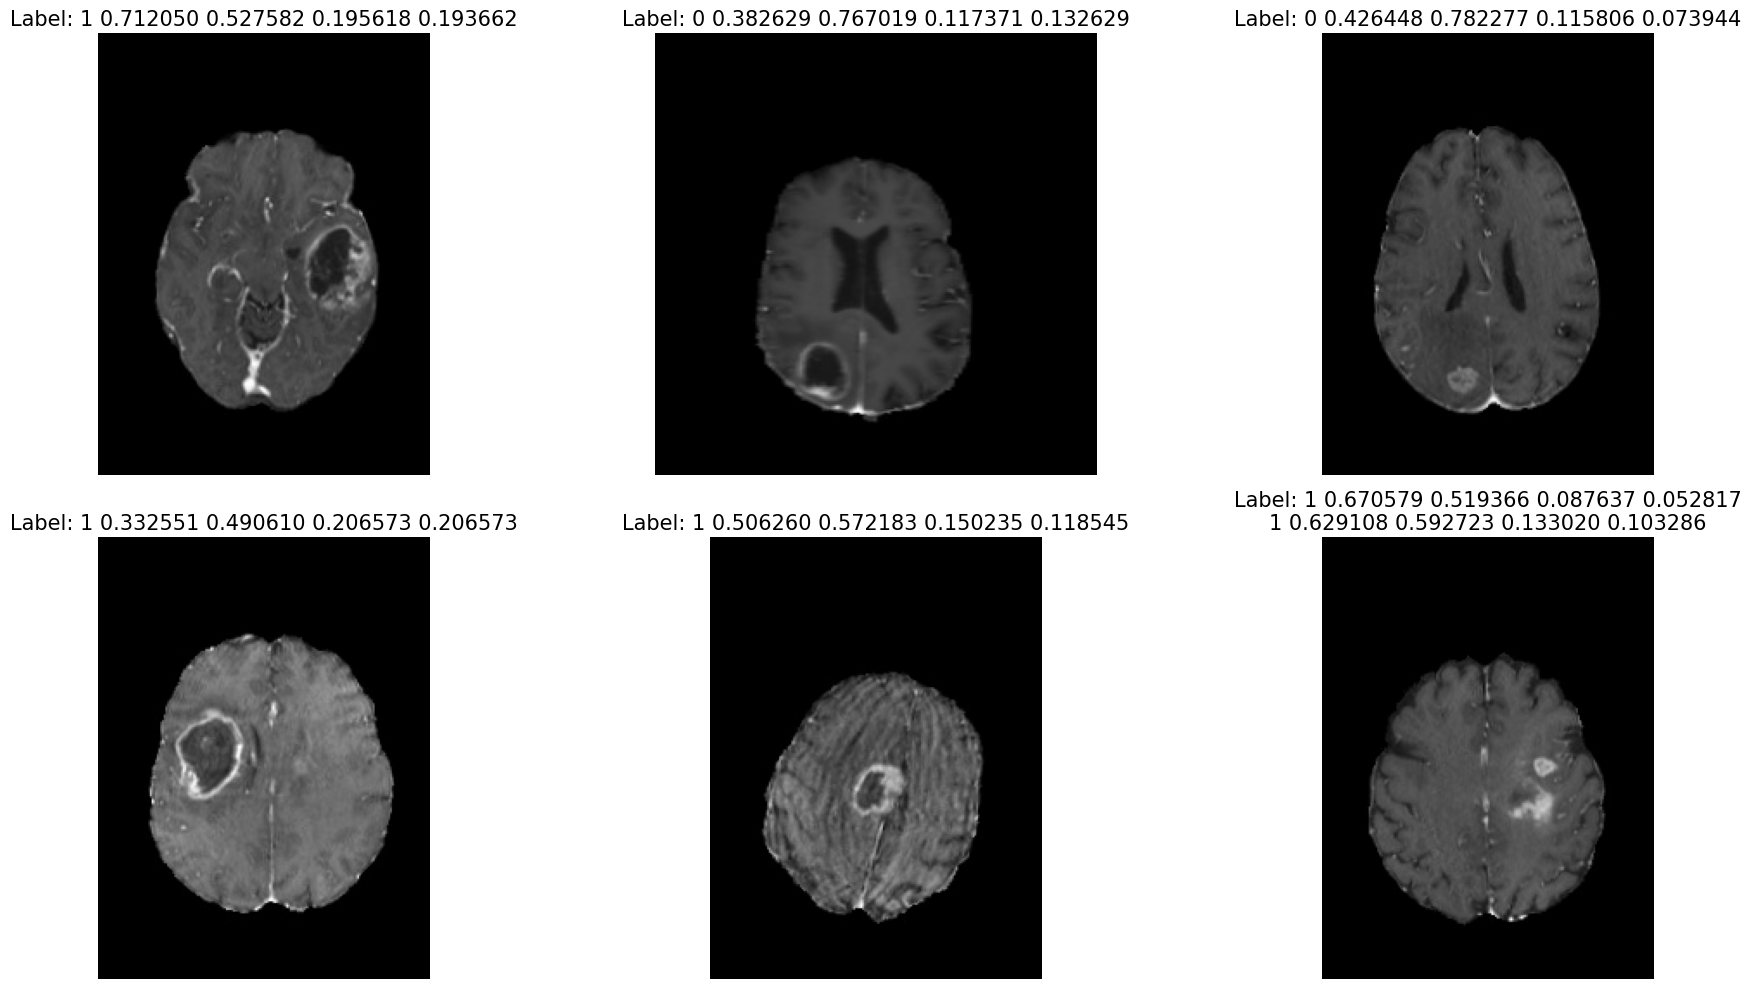

In [7]:
num_rows = 2
num_cols = 3

show_random_images_from_train(TRAIN_DIR, num_rows, num_cols)

## 2. 모델링

### YOLO
0. 설치: pip install ultralytics
1. 데이터셋 준비: YOLO 포맷 (images/, labels/, dataset.yaml)
2. 데이터셋 설정: dataset.yaml 생성 (path, nc, names 설정)
3. YOLO 모델 학습: model.train()
4. 모델 성능 평가: model.val()
5. 객체 탐지 테스트: model()
6. 학습된 모델 저장 및 배포: model.export()


### 1) 모델 로드

In [11]:
model = YOLO('yolov8s.pt') # s: small -> weight의 개수가 적다

### 2) dataset.yaml 파일 작성

* 데이터 경로 및 클래스 정보 정의

In [ ]:
# 데이터셋 디렉토리 구조
# total/
# │── test/
# │   ├── images/
# │   ├── labels/
# │── train/
# │   ├── images/
# │   ├── labels/
# │── val/
# │   ├── images/
# │   ├── labels/
# │── dataset.yaml

In [ ]:
# text = '''
# # dataset path
# path:                   # dataset.yaml이 있는 폴더 절대경로
# train: train/images
# val: val/images
# test: test/images

# # number of classes
# nc: 2

# # class names
# names: ['negative', 'positive']
# '''

In [ ]:
# with open(DATASET_DIR+'/total/dataset.yaml', 'w') as file:
#     file.write(text)

### 3) 모델 학습

In [12]:
MODEL_SAVE_DIR = '../model'
MODEL_SAVE_NAME = '250228_yolov8s_ep200'

# 모델 학습 -> 16m 23s
model.train(data=DATASET_DIR+'/dataset.yaml', epochs=200, project=MODEL_SAVE_DIR, name=MODEL_SAVE_NAME)

Ultralytics 8.3.80  Python-3.10.13 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=../data/brain-tumor-detection-mri/dataset.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=../model, name=250228_yolov8s_ep2002, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save

train: Scanning F:\교육\구름딥다이브\최종프로젝트\ESC\ESC\data\brain-tumor-detection-mri\train\labels.cache... 237 images, 0 backgrounds, 0 corrupt: 100%|██████████| 237/237 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning F:\교육\구름딥다이브\최종프로젝트\ESC\ESC\data\brain-tumor-detection-mri\val\labels.cache... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<?, ?it/s]


Plotting labels to ..\model\250228_yolov8s_ep2002\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ..\model\250228_yolov8s_ep2002
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200       6.9G      1.782      5.707      1.565         27        640: 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all         59         60      0.246       0.41      0.222      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      6.88G      1.288       2.68      1.208         26        640: 100%|██████████| 15/15 [02:38<00:00, 10.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         59         60      0.309      0.479      0.381      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      6.61G        1.2      1.987      1.161         24        640: 100%|██████████| 15/15 [00:05<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         59         60     0.0656      0.368     0.0588     0.0413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      6.88G      1.164      1.698      1.123         23        640: 100%|██████████| 15/15 [00:02<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

                   all         59         60      0.377      0.644      0.374      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      6.88G      1.193       1.59      1.171         19        640: 100%|██████████| 15/15 [00:02<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

                   all         59         60      0.216       0.59      0.294      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      6.88G      1.262      1.514       1.16         21        640: 100%|██████████| 15/15 [00:02<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

                   all         59         60      0.215      0.333      0.203      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200       6.6G      1.288      1.613      1.198         24        640: 100%|██████████| 15/15 [00:02<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         59         60      0.325      0.306      0.201       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      6.61G      1.276       1.45       1.19         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         59         60      0.566      0.486      0.353      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      6.88G       1.21       1.36      1.141         31        640: 100%|██████████| 15/15 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         59         60      0.485      0.771      0.579      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200       6.6G      1.155      1.376      1.145         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         59         60      0.474      0.611      0.525      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200       6.6G      1.176      1.342      1.117         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         59         60      0.461      0.597      0.506      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      6.61G      1.112      1.297      1.096         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]

                   all         59         60      0.289       0.59      0.376      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      6.73G      1.146      1.328      1.144         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         59         60      0.383      0.632      0.512       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200       6.6G      1.147      1.288      1.133         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         59         60      0.406      0.742      0.609        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200       6.6G      1.065      1.187      1.094         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

                   all         59         60      0.362      0.569      0.473      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      6.61G      1.139      1.233      1.124         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         59         60      0.642      0.497      0.552      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      6.73G      1.147      1.244      1.132         27        640: 100%|██████████| 15/15 [00:03<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         59         60      0.549      0.743       0.66      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200       6.6G      1.145      1.165      1.103         25        640: 100%|██████████| 15/15 [00:03<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         59         60      0.475      0.726      0.677      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200       6.6G      1.109      1.146       1.09         26        640: 100%|██████████| 15/15 [00:03<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         59         60      0.614      0.649      0.689      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      6.61G      1.027      1.122      1.052         26        640: 100%|██████████| 15/15 [00:03<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         59         60      0.581      0.764      0.737       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      6.88G      1.074      1.121      1.101         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         59         60      0.591      0.667      0.677      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200       6.6G      1.151      1.132      1.141         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         59         60      0.733      0.688      0.795      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200       6.6G      1.084      1.113      1.083         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         59         60      0.598      0.653        0.7      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      6.61G      1.012      1.023      1.064         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         59         60      0.477      0.889      0.612      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      6.88G      1.107      1.153      1.105         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all         59         60      0.619      0.688      0.723      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200       6.6G     0.9929      1.075      1.057         27        640: 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         59         60      0.736       0.71      0.797      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200       6.6G     0.9807      1.066      1.049         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         59         60      0.501      0.736      0.717      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      6.61G     0.9839     0.9848      1.035         13        640: 100%|██████████| 15/15 [00:03<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         59         60      0.612      0.778      0.794      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      6.88G      1.005     0.9409      1.028         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:38<00:00, 19.27s/it]

                   all         59         60      0.599      0.803      0.741      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200       6.6G     0.9936     0.9767      1.049         16        640: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         59         60      0.616      0.764      0.746      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200       6.6G      1.018     0.9396      1.076         26        640: 100%|██████████| 15/15 [00:03<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         59         60      0.556      0.681      0.615      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      6.61G     0.9825      1.001      1.052         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

                   all         59         60      0.602      0.653      0.714      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      6.88G      1.047     0.9784      1.083         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

                   all         59         60      0.576       0.81      0.729      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200       6.6G     0.9844     0.9353      1.043         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         59         60      0.579      0.771      0.723      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200       6.6G     0.9964     0.9314      1.033         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

                   all         59         60      0.714      0.789      0.884      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      6.61G     0.9323     0.8971      1.024         12        640: 100%|██████████| 15/15 [00:03<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         59         60      0.754      0.479      0.583      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      6.88G     0.9922      0.921      1.066         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         59         60      0.761      0.659      0.752        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200       6.6G     0.9912      0.928      1.043         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         59         60      0.649      0.729      0.782      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200       6.6G      1.004     0.9608      1.055         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         59         60      0.553      0.743      0.644      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      6.61G     0.9479     0.8492       1.02         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         59         60      0.618      0.735       0.73      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      6.88G     0.9711     0.8627      1.034         15        640: 100%|██████████| 15/15 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         59         60        0.7      0.743      0.805      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200       6.6G     0.9094     0.7913      1.012         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         59         60      0.733       0.84      0.869      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200       6.6G     0.9119     0.8074      1.011         29        640: 100%|██████████| 15/15 [00:03<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         59         60      0.721       0.82      0.858      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      6.61G     0.9206     0.7733      1.021         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         59         60      0.893      0.885      0.891      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      6.88G     0.9499     0.7942      1.016         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         59         60      0.723      0.808      0.836      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200       6.6G     0.9461     0.7945      1.034         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         59         60      0.783      0.903       0.91      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200       6.6G     0.9249     0.7899      1.023         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         59         60      0.718       0.84      0.868       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      6.61G     0.9001     0.7806     0.9995         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         59         60      0.627      0.799      0.755      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      6.88G       0.92     0.7735      1.015         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         59         60      0.811      0.826       0.89      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200       6.6G     0.9119     0.7901     0.9993         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

                   all         59         60      0.792      0.841      0.874      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200       6.6G     0.8753      0.714     0.9917         25        640: 100%|██████████| 15/15 [00:03<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         59         60      0.771      0.819      0.844      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      6.61G     0.9194     0.7453      1.003         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         59         60      0.819      0.807      0.859      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      6.88G     0.8484     0.6595     0.9853         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [02:43<00:00, 81.75s/it]

                   all         59         60      0.606      0.887      0.792      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200       6.6G     0.8376     0.7071     0.9653         21        640: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

                   all         59         60      0.674      0.806      0.827       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200       6.6G     0.8858     0.7466          1         30        640: 100%|██████████| 15/15 [00:03<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         59         60      0.768      0.786      0.874      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      6.61G     0.8464     0.6945     0.9884         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         59         60      0.782      0.814      0.887      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      6.88G     0.9078     0.7811      1.013         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         59         60      0.726      0.778      0.808      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200       6.6G     0.8998     0.6973     0.9905         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all         59         60      0.599      0.812      0.698      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200       6.6G     0.8839     0.7078     0.9935         25        640: 100%|██████████| 15/15 [00:03<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

                   all         59         60      0.679      0.847      0.774      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      6.61G     0.8638     0.6983     0.9932         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]

                   all         59         60      0.762       0.77      0.827      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      6.88G     0.8502     0.6782      0.975         26        640: 100%|██████████| 15/15 [00:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         59         60      0.673      0.846      0.816      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200       6.6G     0.8767     0.6507      1.007         16        640: 100%|██████████| 15/15 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]

                   all         59         60      0.818      0.808      0.856      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200       6.6G     0.8396     0.6531     0.9976         35        640: 100%|██████████| 15/15 [00:03<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         59         60      0.794      0.854      0.863      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      6.61G     0.8406     0.6401      0.973         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]

                   all         59         60      0.837      0.806      0.904      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      6.88G     0.8375     0.6481       0.99         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all         59         60      0.873      0.826      0.869       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200       6.6G     0.8427     0.6755     0.9764         18        640: 100%|██████████| 15/15 [00:03<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         59         60      0.808      0.831      0.927      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200       6.6G     0.8828      0.641     0.9824         26        640: 100%|██████████| 15/15 [00:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         59         60      0.657      0.833       0.83      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      6.61G     0.8731     0.6796     0.9988         15        640: 100%|██████████| 15/15 [00:03<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

                   all         59         60      0.795      0.826      0.884      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      6.88G      0.836     0.6749     0.9757         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         59         60      0.757      0.943      0.918       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200       6.6G     0.8095     0.6342     0.9655         27        640: 100%|██████████| 15/15 [00:03<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.31it/s]

                   all         59         60      0.838      0.795      0.919      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200       6.6G     0.8461     0.6459     0.9727         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]

                   all         59         60      0.707      0.875      0.843       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      6.61G     0.7794     0.5945     0.9624         18        640: 100%|██████████| 15/15 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

                   all         59         60      0.936      0.854       0.94       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      6.88G     0.8551     0.6377     0.9794         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         59         60      0.765      0.875      0.918      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200       6.6G     0.8044     0.5885     0.9795         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

                   all         59         60      0.641      0.866      0.859      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200       6.6G     0.8393     0.6226     0.9704         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         59         60      0.654       0.92      0.849      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      6.61G      0.827      0.585     0.9624         32        640: 100%|██████████| 15/15 [00:03<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         59         60      0.826      0.847      0.919      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      6.88G     0.8371     0.5809      0.968         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         59         60      0.854      0.888      0.928      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200       6.6G     0.7826     0.6129      0.959         14        640: 100%|██████████| 15/15 [00:03<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.62it/s]

                   all         59         60      0.923      0.799      0.926      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200       6.6G     0.8036     0.6275     0.9647         15        640: 100%|██████████| 15/15 [00:05<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.25it/s]

                   all         59         60      0.732      0.799      0.837      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      6.61G     0.8487     0.6473     0.9854         16        640: 100%|██████████| 15/15 [00:03<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]

                   all         59         60      0.815      0.868      0.907      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      6.88G      0.808     0.5698     0.9823         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         59         60       0.78      0.879       0.89      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200       6.6G     0.7502     0.5275     0.9507         18        640: 100%|██████████| 15/15 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

                   all         59         60      0.819      0.842      0.887      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200       6.6G     0.7969     0.5807     0.9571         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]

                   all         59         60      0.753        0.9      0.884      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      6.61G     0.7547     0.6033     0.9478         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.91it/s]

                   all         59         60      0.901      0.826      0.932      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      6.88G     0.7619     0.5855     0.9454         26        640: 100%|██████████| 15/15 [00:03<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         59         60      0.813       0.89      0.949      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200       6.6G     0.7656     0.5696      0.969         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]

                   all         59         60      0.857      0.918      0.947      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200       6.6G     0.7628     0.5475     0.9503         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]

                   all         59         60      0.893      0.871      0.946      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      6.61G     0.7775     0.5406     0.9533         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.22it/s]

                   all         59         60      0.912      0.791      0.934      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      6.88G     0.7881     0.5267     0.9532         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         59         60      0.883      0.893      0.937      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200       6.6G     0.7709     0.5625     0.9555         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

                   all         59         60      0.845      0.887       0.93      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200       6.6G      0.786      0.564     0.9634         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]

                   all         59         60      0.873       0.85      0.927      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      6.61G     0.7501     0.5408     0.9629         33        640: 100%|██████████| 15/15 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]

                   all         59         60      0.857      0.936      0.946      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      6.88G     0.7408     0.5031      0.936         25        640: 100%|██████████| 15/15 [00:03<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         59         60      0.932      0.829      0.937      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200       6.6G     0.7317     0.5132     0.9531         16        640: 100%|██████████| 15/15 [00:03<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]

                   all         59         60      0.851      0.868      0.939      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200       6.6G       0.73     0.5312     0.9261         27        640: 100%|██████████| 15/15 [00:03<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]

                   all         59         60      0.923      0.834      0.948      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      6.61G     0.7651     0.5191     0.9434         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

                   all         59         60      0.827      0.944      0.952      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      6.88G     0.7362     0.5207     0.9344         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         59         60      0.862      0.856      0.926      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200       6.6G     0.7568     0.5653     0.9631         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.17it/s]

                   all         59         60      0.858       0.86      0.917      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200       6.6G     0.7289     0.5973     0.9572         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]

                   all         59         60      0.744      0.843      0.852      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      6.61G     0.7214     0.5621     0.9376         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

                   all         59         60      0.846      0.903      0.926      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      6.88G     0.6816     0.4967     0.9206         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         59         60      0.859      0.826      0.922      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200       6.6G     0.7214     0.5406     0.9247         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         59         60      0.905      0.818       0.91       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200       6.6G     0.7079     0.5113     0.9366         26        640: 100%|██████████| 15/15 [00:03<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         59         60      0.885      0.813      0.935      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      6.61G     0.7241     0.5399     0.9348         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.25it/s]

                   all         59         60      0.814      0.847      0.922      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      6.88G     0.7179     0.5123     0.9416         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         59         60      0.878      0.761      0.918      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200       6.6G     0.6904     0.4769      0.925         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

                   all         59         60      0.924      0.771      0.913      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200       6.6G     0.7273     0.5333     0.9563         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.06it/s]

                   all         59         60      0.967      0.806      0.928      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      6.61G     0.6999     0.4757     0.9223         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         59         60      0.957      0.804      0.942      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      6.88G     0.7057     0.4938     0.9303         18        640: 100%|██████████| 15/15 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         59         60      0.765      0.925      0.922      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200       6.6G     0.6796      0.503     0.9288         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

                   all         59         60      0.802      0.857      0.923      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200       6.6G     0.7554     0.5667     0.9813         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

                   all         59         60      0.891      0.764      0.902      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      6.61G     0.6773     0.4873     0.9142         26        640: 100%|██████████| 15/15 [00:03<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]

                   all         59         60      0.785      0.841      0.897      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      6.88G     0.6807     0.4878     0.9328         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         59         60      0.868      0.867      0.924      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200       6.6G     0.7011     0.5033     0.9614         12        640: 100%|██████████| 15/15 [00:03<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

                   all         59         60      0.896      0.867      0.937      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200       6.6G     0.6706     0.4345       0.92         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]

                   all         59         60      0.872        0.9      0.913      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      6.61G     0.6792     0.4365     0.9104         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         59         60      0.815      0.836      0.911      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      6.88G     0.6636     0.4863     0.9162         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         59         60      0.787      0.948      0.926      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200       6.6G     0.6838     0.4361     0.9264         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         59         60      0.847      0.847      0.909      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200       6.6G     0.6742     0.4819     0.9506         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

                   all         59         60      0.798      0.972      0.944      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      6.61G     0.6426     0.4385     0.9043         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         59         60       0.85      0.869      0.924      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      6.88G     0.6843      0.498     0.9252         18        640: 100%|██████████| 15/15 [00:03<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]


                   all         59         60      0.841      0.867      0.915       0.67

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200       6.6G     0.6652      0.439     0.9322         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         59         60      0.832      0.903      0.928      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200       6.6G     0.6667     0.4288     0.9328         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]

                   all         59         60       0.93      0.951       0.97      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      6.61G     0.6706     0.4433     0.9197         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]

                   all         59         60      0.934      0.949      0.977      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      6.88G     0.6282     0.4466      0.895         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         59         60      0.938      0.905      0.963      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200       6.6G     0.6225     0.4265     0.9138         25        640: 100%|██████████| 15/15 [00:03<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

                   all         59         60      0.923      0.895      0.952      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200       6.6G     0.6513     0.4251     0.9241         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

                   all         59         60      0.831      0.943      0.948      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      6.61G     0.6211     0.4362     0.8981         18        640: 100%|██████████| 15/15 [00:03<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]

                   all         59         60      0.809      0.888      0.926      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      6.88G      0.608     0.4231     0.8935         12        640: 100%|██████████| 15/15 [00:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         59         60      0.755       0.93      0.917      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200       6.6G     0.5941     0.3981     0.8856         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         59         60      0.932      0.844      0.943      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200       6.6G     0.6269     0.4588     0.9299         30        640: 100%|██████████| 15/15 [00:07<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.22it/s]

                   all         59         60      0.794      0.816      0.894      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      6.61G       0.62     0.4796     0.9071         18        640: 100%|██████████| 15/15 [00:03<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         59         60      0.916      0.882      0.957      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      6.88G     0.6148     0.4372     0.9078         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         59         60      0.952      0.889      0.964      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200       6.6G      0.589     0.4111     0.9034         31        640: 100%|██████████| 15/15 [00:03<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

                   all         59         60      0.934      0.889      0.964      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200       6.6G      0.637     0.4181     0.9028         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

                   all         59         60       0.94      0.887       0.95      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      6.61G     0.6354      0.423     0.9206         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]

                   all         59         60      0.924      0.867      0.949      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      6.88G     0.6289     0.4316     0.9057         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

                   all         59         60      0.902      0.819       0.92      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200       6.6G     0.6213      0.447     0.9019         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

                   all         59         60      0.886      0.868      0.924      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200       6.6G      0.597     0.4045     0.9149         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]

                   all         59         60      0.891       0.92      0.957      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      6.61G     0.5858     0.4185      0.912         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]

                   all         59         60       0.81      0.925      0.945      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      6.88G      0.564     0.3745       0.88         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.55it/s]

                   all         59         60      0.819      0.951      0.952      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200       6.6G     0.5792     0.3839     0.8969         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.41it/s]

                   all         59         60      0.754      0.909      0.927      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200       6.6G     0.5888     0.4203     0.9134         32        640: 100%|██████████| 15/15 [00:03<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.22it/s]

                   all         59         60      0.877      0.871      0.919       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      6.61G     0.6043     0.4104     0.9006         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

                   all         59         60      0.957      0.895      0.937      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      6.88G     0.6043     0.4118     0.9216         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         59         60      0.919      0.889      0.957      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200       6.6G     0.5944      0.408     0.9053         27        640: 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

                   all         59         60      0.918      0.861      0.956      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200       6.6G     0.6184     0.4138     0.9029         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.31it/s]

                   all         59         60      0.891      0.913      0.959      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      6.61G     0.6379     0.4146     0.9036         25        640: 100%|██████████| 15/15 [00:03<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]

                   all         59         60      0.974      0.917      0.967      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      6.88G     0.6231     0.4061      0.906         18        640: 100%|██████████| 15/15 [00:03<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.17it/s]

                   all         59         60      0.942      0.867      0.952      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200       6.6G      0.564     0.3906     0.8771         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

                   all         59         60      0.956      0.907      0.962      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200       6.6G     0.5731     0.3855     0.8925         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]

                   all         59         60      0.906      0.891      0.957      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      6.61G     0.5433     0.3706     0.8858         27        640: 100%|██████████| 15/15 [00:03<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

                   all         59         60      0.918      0.908      0.963      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      6.88G     0.5332     0.3706     0.8863         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         59         60      0.935      0.918      0.968      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200       6.6G      0.536     0.3797     0.8732         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

                   all         59         60       0.94      0.906      0.964      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200       6.6G     0.5584     0.3834     0.8919         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

                   all         59         60      0.915      0.889      0.956       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      6.61G     0.5938     0.3796     0.8905         25        640: 100%|██████████| 15/15 [00:03<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         59         60      0.898      0.861       0.95      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      6.88G     0.5436     0.3647     0.8736         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.00it/s]

                   all         59         60      0.912      0.871       0.95      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200       6.6G     0.5427     0.3608     0.8867         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

                   all         59         60       0.87      0.826      0.928      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200       6.6G     0.5922     0.3828     0.8918         30        640: 100%|██████████| 15/15 [00:03<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

                   all         59         60      0.903      0.864      0.952      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      6.61G     0.6009     0.3981      0.901         26        640: 100%|██████████| 15/15 [00:03<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

                   all         59         60      0.897      0.896      0.959      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      6.88G      0.548     0.3666      0.877         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         59         60       0.91      0.933      0.968      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200       6.6G     0.5466     0.3643     0.9057         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

                   all         59         60      0.947      0.938      0.976      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200       6.6G     0.5576      0.375     0.8788         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

                   all         59         60      0.938      0.905      0.963      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      6.61G     0.5026      0.354     0.8674         13        640: 100%|██████████| 15/15 [00:03<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         59         60      0.935      0.931      0.979      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      6.88G     0.5272      0.374      0.891         29        640: 100%|██████████| 15/15 [00:03<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         59         60      0.932      0.958      0.976      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200       6.6G     0.5251     0.3421     0.8832         25        640: 100%|██████████| 15/15 [00:03<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

                   all         59         60       0.87      0.979      0.964      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200       6.6G      0.506     0.3265      0.862         25        640: 100%|██████████| 15/15 [00:03<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

                   all         59         60      0.967      0.847      0.962      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      6.61G     0.5211     0.3468     0.8647         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]

                   all         59         60      0.907      0.826      0.937      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      6.88G     0.5068     0.3382     0.8792         25        640: 100%|██████████| 15/15 [00:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         59         60       0.85       0.91      0.947       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200       6.6G     0.5283     0.3762     0.8725         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

                   all         59         60      0.821      0.961      0.956      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200       6.6G     0.5207     0.3491     0.8911         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

                   all         59         60      0.889      0.922       0.96      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      6.61G     0.5027     0.3495     0.8678         27        640: 100%|██████████| 15/15 [00:03<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.25it/s]

                   all         59         60      0.876      0.958      0.962      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      6.88G      0.512     0.3631      0.883         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         59         60      0.886      0.951       0.96      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200       6.6G     0.5065     0.3489     0.8598         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]

                   all         59         60      0.931      0.897      0.961       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200       6.6G     0.5354      0.352     0.8768         28        640: 100%|██████████| 15/15 [00:03<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]

                   all         59         60      0.888      0.958      0.971      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      6.61G     0.4644     0.3088     0.8401         27        640: 100%|██████████| 15/15 [00:03<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.63it/s]

                   all         59         60      0.912      0.976      0.975      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      6.88G     0.5131     0.3639     0.8795         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

                   all         59         60      0.904      0.975      0.974      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200       6.6G     0.5145     0.3324     0.8835         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.24it/s]

                   all         59         60      0.912      0.957      0.968      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200       6.6G     0.4828     0.3299     0.8595         18        640: 100%|██████████| 15/15 [00:03<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

                   all         59         60      0.906      0.944      0.973      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      6.61G     0.4966     0.3313     0.8777         20        640: 100%|██████████| 15/15 [00:03<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

                   all         59         60      0.947      0.917      0.973      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      6.88G     0.4894     0.3292     0.8635         22        640: 100%|██████████| 15/15 [00:03<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         59         60      0.949      0.918      0.973      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200       6.6G     0.5035      0.328     0.8651         23        640: 100%|██████████| 15/15 [00:03<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         59         60        0.9      0.956      0.975      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200       6.6G     0.4806     0.3504      0.862         29        640: 100%|██████████| 15/15 [00:03<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]

                   all         59         60      0.913      0.954      0.973      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      6.61G     0.5396     0.3554     0.8895         24        640: 100%|██████████| 15/15 [00:03<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

                   all         59         60      0.969       0.91      0.976      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      6.88G     0.4829     0.3277     0.8686         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         59         60      0.945       0.91      0.975      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200       6.6G     0.4887     0.3375     0.8632         27        640: 100%|██████████| 15/15 [00:03<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

                   all         59         60      0.954       0.91      0.978      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200       6.6G     0.5015     0.3288     0.8801         26        640: 100%|██████████| 15/15 [00:03<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

                   all         59         60       0.96      0.919      0.978      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      6.61G     0.4837     0.3215     0.8721         19        640: 100%|██████████| 15/15 [00:03<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]

                   all         59         60      0.936       0.94      0.977      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      6.88G     0.4536      0.322     0.8498         17        640: 100%|██████████| 15/15 [00:03<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

                   all         59         60      0.954      0.932       0.98      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200       6.6G     0.4987     0.3334     0.8855         21        640: 100%|██████████| 15/15 [00:03<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

                   all         59         60       0.95       0.93      0.979      0.723


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200       6.6G     0.4107     0.2465     0.8209         13        640: 100%|██████████| 15/15 [00:03<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]

                   all         59         60      0.899      0.971       0.98      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      6.61G     0.4024     0.2452      0.815         14        640: 100%|██████████| 15/15 [00:02<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

                   all         59         60      0.933      0.914      0.977      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      6.88G     0.3856     0.2458     0.8218         14        640: 100%|██████████| 15/15 [00:02<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         59         60      0.959      0.889      0.977      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200       6.6G      0.383     0.2439     0.8049         13        640: 100%|██████████| 15/15 [00:02<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.41it/s]

                   all         59         60      0.954      0.889      0.978      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200       6.6G     0.4129     0.2507     0.8358         13        640: 100%|██████████| 15/15 [00:02<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

                   all         59         60      0.958      0.891      0.977      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      6.61G     0.3701     0.2395     0.8179         15        640: 100%|██████████| 15/15 [00:02<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

                   all         59         60      0.972      0.913      0.977      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      6.88G     0.3961     0.2519     0.8147         14        640: 100%|██████████| 15/15 [00:02<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]

                   all         59         60      0.968      0.913      0.977      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200       6.6G     0.3945      0.257     0.8091         13        640: 100%|██████████| 15/15 [00:02<00:00,  5.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         59         60      0.963      0.914      0.976      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200       6.6G     0.3657     0.2404     0.8285         14        640: 100%|██████████| 15/15 [00:02<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         59         60      0.961       0.91      0.977      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      6.61G     0.3823     0.2327     0.8092         14        640: 100%|██████████| 15/15 [00:02<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]

                   all         59         60      0.958       0.91      0.976      0.719



200 epochs completed in 0.381 hours.
Optimizer stripped from ..\model\250228_yolov8s_ep2002\weights\last.pt, 22.5MB
Optimizer stripped from ..\model\250228_yolov8s_ep2002\weights\best.pt, 22.5MB

Validating ..\model\250228_yolov8s_ep2002\weights\best.pt...
Ultralytics 8.3.80  Python-3.10.13 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]


                   all         59         60      0.954       0.91      0.978      0.727
              negative         24         24      0.946      0.875      0.966      0.707
              positive         35         36      0.961      0.944       0.99      0.747
Speed: 0.3ms preprocess, 3.7ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to ..\model\250228_yolov8s_ep2002


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001270E4DF850>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

### 4) 학습 결과

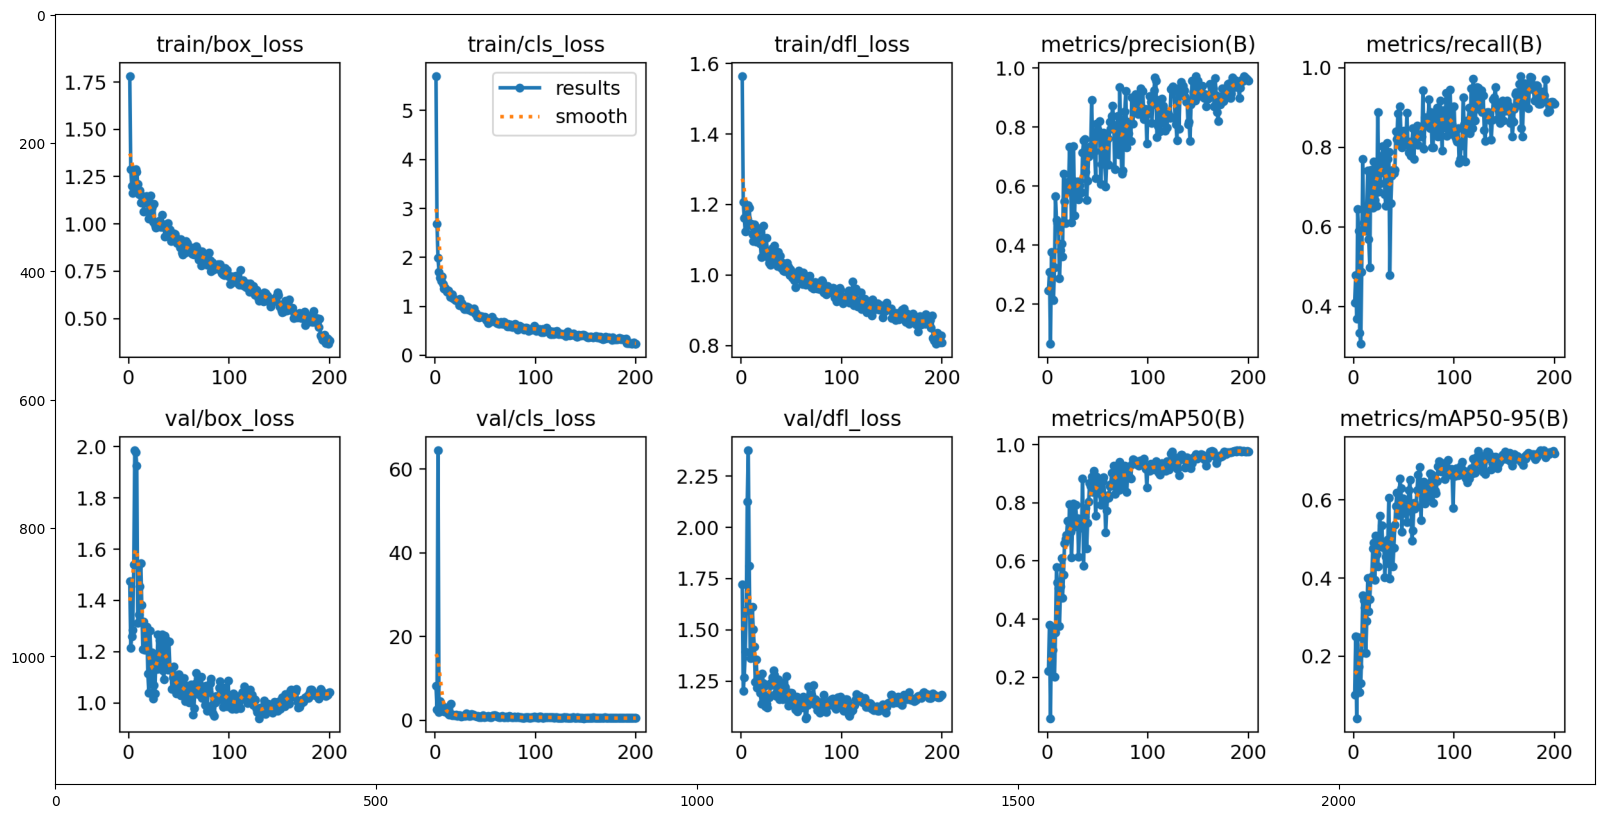

In [14]:
# results
MODEL_DIR = MODEL_SAVE_DIR+'/'+MODEL_SAVE_NAME

plt.figure(figsize=(20, 10))
img = Image.open(MODEL_DIR+'/results.png')
plt.imshow(img)
plt.show()

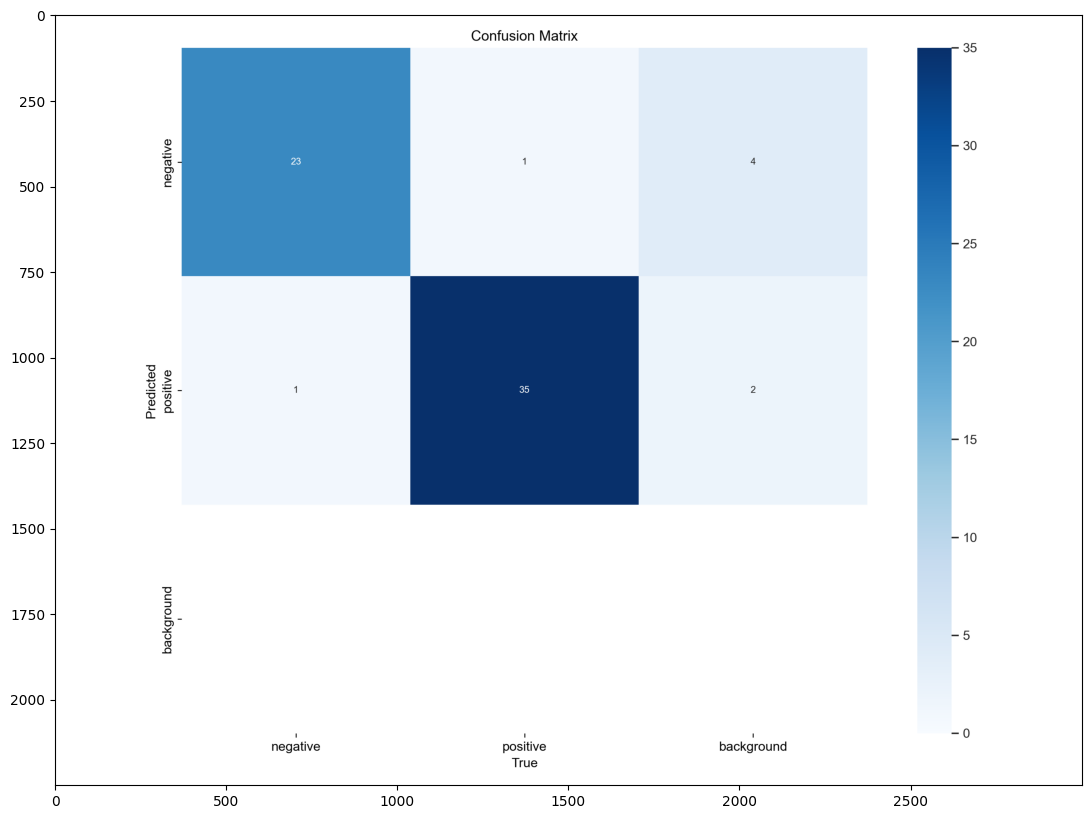

In [15]:
# confusion matrix
plt.figure(figsize=(20, 10))
img = Image.open(MODEL_DIR+'/confusion_matrix.png')
plt.imshow(img)
plt.show()

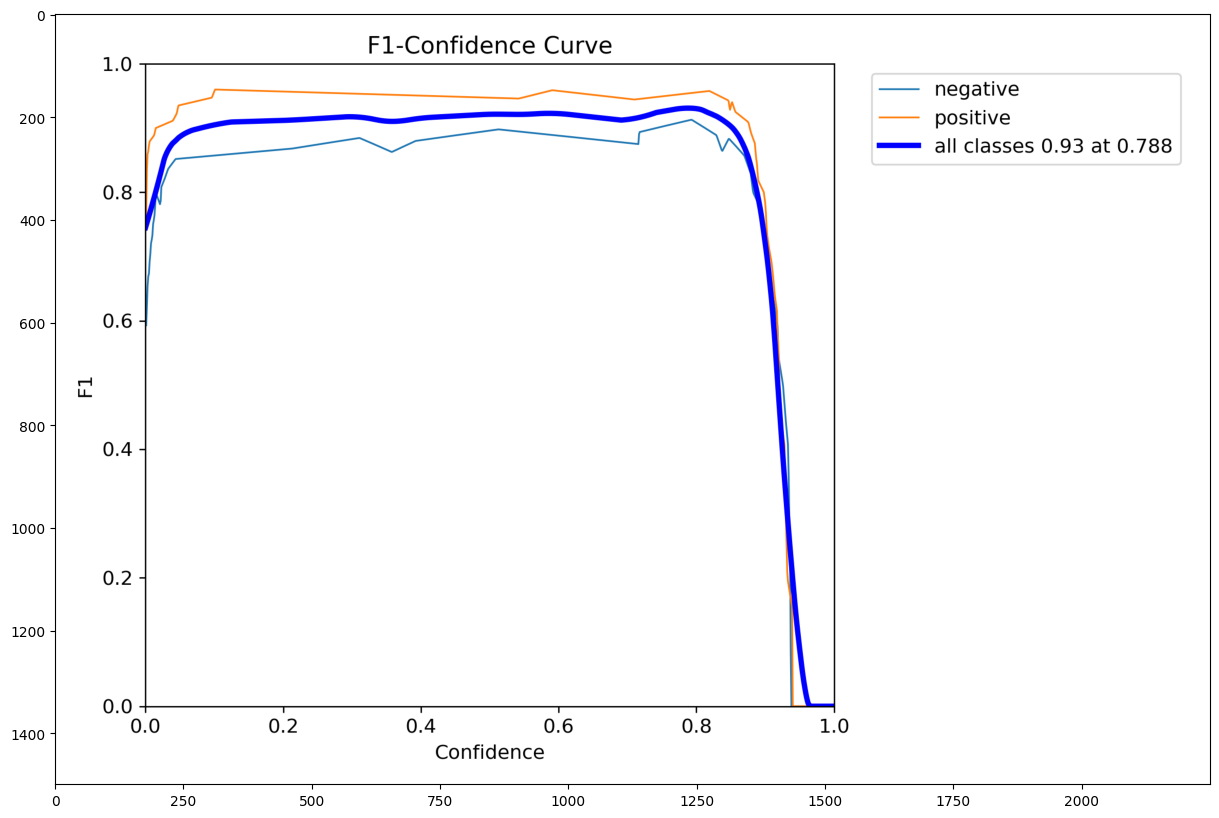

In [29]:
# F1_curve
plt.figure(figsize=(20, 10))
img = Image.open(MODEL_DIR+'/F1_curve.png')
plt.imshow(img)
plt.show()

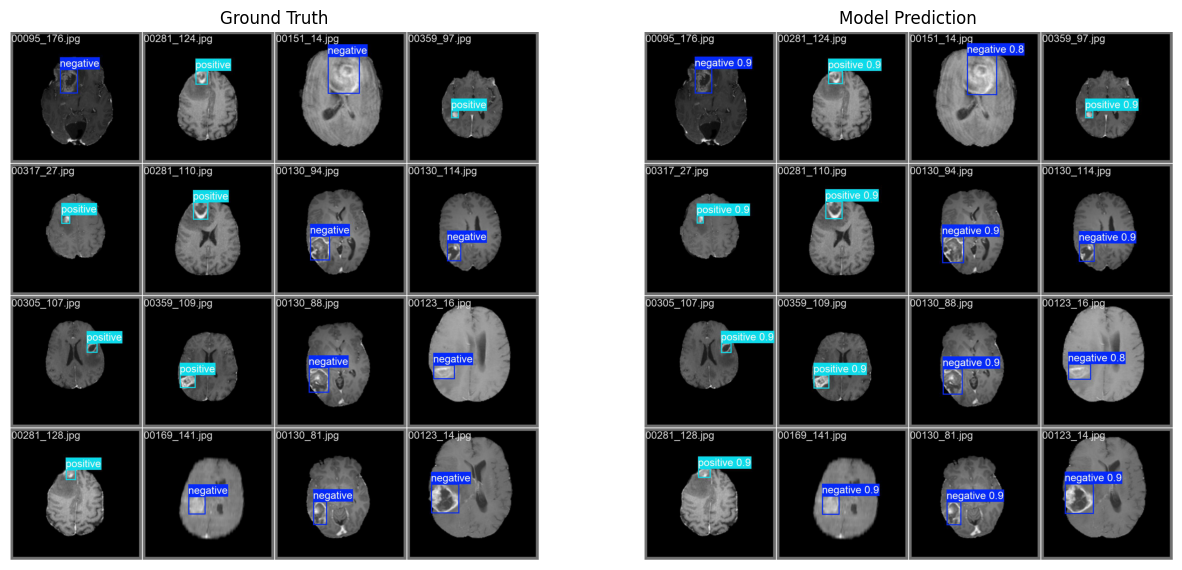

In [16]:
# 검증 데이터 실제
img_actual = Image.open(MODEL_DIR+'/val_batch0_labels.jpg')
img_pred = Image.open(MODEL_DIR+'/val_batch0_pred.jpg')

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(img_actual)
axes[0].set_title('Ground Truth')
axes[0].axis('off')

axes[1].imshow(img_pred)
axes[1].set_title('Model Prediction')
axes[1].axis('off')

plt.show()

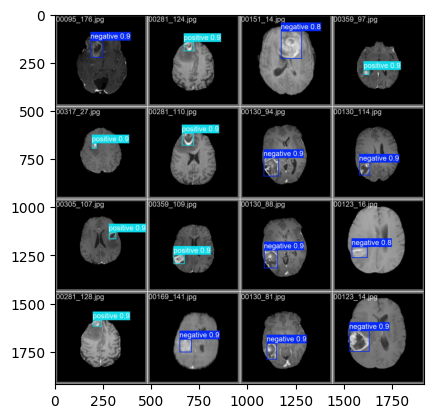

In [17]:
# 검증 데이터 예측
img = Image.open(MODEL_DIR+'/val_batch0_pred.jpg')
plt.imshow(img)
plt.show()

### 5) 성능 평가

In [18]:
best_weight = os.path.join(MODEL_DIR, 'weights/best.pt')
test_images = os.path.join(TEST_DIR, 'images')
test_labels = os.path.join(TEST_DIR, 'labels')

In [19]:
# 평가 데이터셋으로 테스트
model = YOLO(best_weight)
results = model.predict(source=test_images, conf=0.25)


image 1/75 f:\\\\ESC\ESC\real\..\data\brain-tumor-detection-mri\test\images\00018_101.jpg: 640x640 2 negatives, 17.8ms
image 2/75 f:\\\\ESC\ESC\real\..\data\brain-tumor-detection-mri\test\images\00018_109.jpg: 640x640 1 negative, 10.2ms
image 3/75 f:\\\\ESC\ESC\real\..\data\brain-tumor-detection-mri\test\images\00018_111.jpg: 640x640 1 negative, 10.6ms
image 4/75 f:\\\\ESC\ESC\real\..\data\brain-tumor-detection-mri\test\images\00018_117.jpg: 640x640 1 negative, 10.1ms
image 5/75 f:\\\\ESC\ESC\real\..\data\brain-tumor-detection-mri\test\images\00018_121.jpg: 640x640 1 negative, 7.2ms
image 6/75 f:\\\\ESC\ESC\real\..\data\brain-tumor-detection-mri\test\images\00018_126.jpg: 640x640 1 negative, 9.9ms
image 7/75 f:\\\\ESC\ESC\real\..\data\brain-tumor-detection-mri\test\images\00018_134.jpg: 640x640 (no detections), 10.6ms
image 8/75 f:\\\\ESC\ESC\real\..\data\brain-tumor-detection-mri\test\images\00019_66.jpg: 640x640 1 negative, 6.9ms
image 9/75 f:\\\\ESC\ESC\real\..\data\brain-tumor-det

In [20]:
results[0]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'negative', 1: 'positive'}
obb: None
orig_img: array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
orig_sh

In [21]:
# 이미지 + 라벨 (바운딩박스 포함)
def draw_img_label(img, label, thickness=2):

    x_size, y_size = img.size # 실제 이미지 크기
    label_text, cx, cy, w, h = label # class, 중심 좌표(정규화된 값), 바운딩 박스의 너비와 높이(정규화된 값)
    
    # YOLO 좌표 -> 실제 픽셀 좌표
    cx *= x_size
    cy *= y_size
    w *= x_size
    h *= y_size

    draw = ImageDraw.Draw(img) # 이미지 위에 그래픽을 그릴 수 있도록 하는 객체 생성
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)), outline='white', width=thickness) # 바운딩 박스 (좌측 상단, 우측 하단 -> 이미지 좌표는 4사분면에 그려짐)
    draw.text((cx-w/2, cy-h/2-15), str(label_text), fill='white') # class 이름 표시 (바운딩 박스 좌측 상단보다 조금 더 위)

    return img

In [22]:
def show_predicted_vs_real(index):

    # 모델 예측 결과 이미지
    pred_result = results[index]
    pred_image = pred_result.plot()

    # 실제 데이터 이미지
    image_name = os.path.basename(pred_result.path)
    real_path = os.path.join(test_images, image_name)
    real_image = Image.open(real_path)
    
    # 실제 데이터 라벨
    label_path = os.path.join(test_labels, os.path.splitext(image_name)[0] + '.txt')
    with open(label_path, 'r') as f:
        label = tuple(map(float, f.readline().split()))

    # 실제 데이터 이미지+라벨
    image_with_label = draw_img_label(real_image, label)

    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(pred_image)
    axes[0].set_title('Predicted Image (YOLO)')
    axes[0].axis('off')

    axes[1].imshow(image_with_label, cmap='gray')
    axes[1].set_title('Original Image (With Label)')
    axes[1].axis('off')

    plt.show()

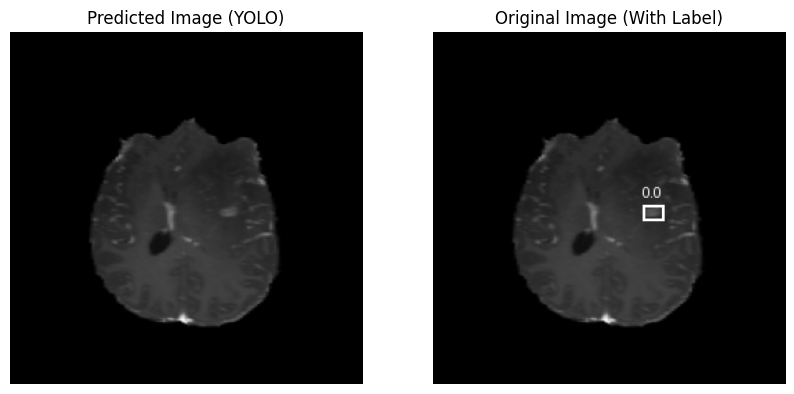

In [23]:
show_predicted_vs_real(index=10)

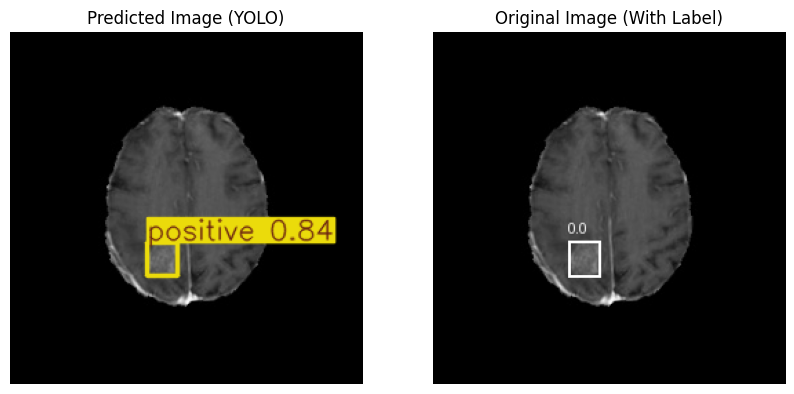

In [24]:
show_predicted_vs_real(index=20)

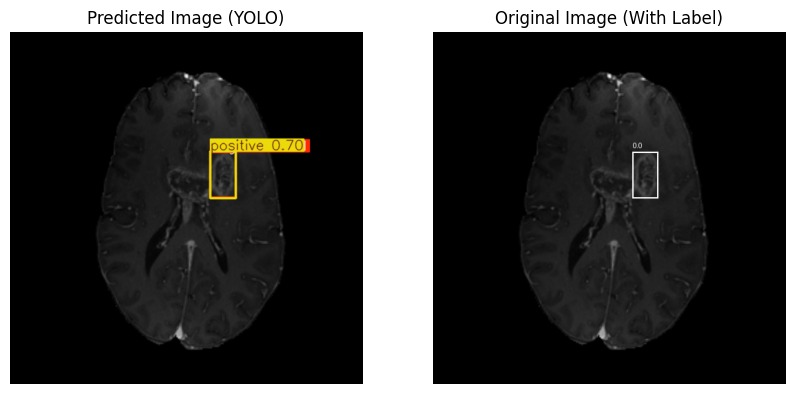

In [25]:
show_predicted_vs_real(index=30)

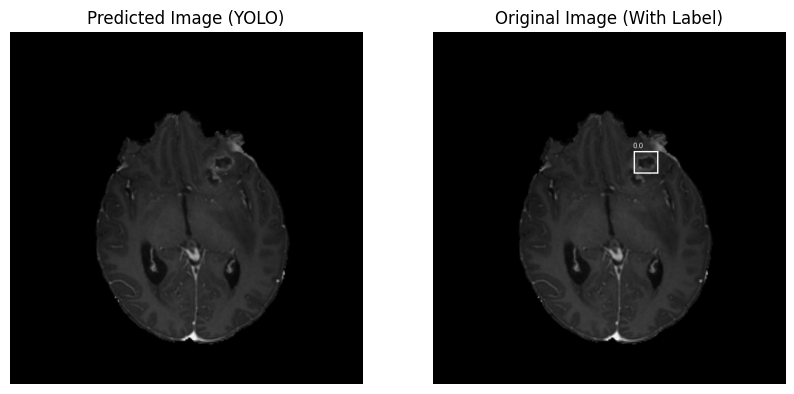

In [26]:
show_predicted_vs_real(index=40)

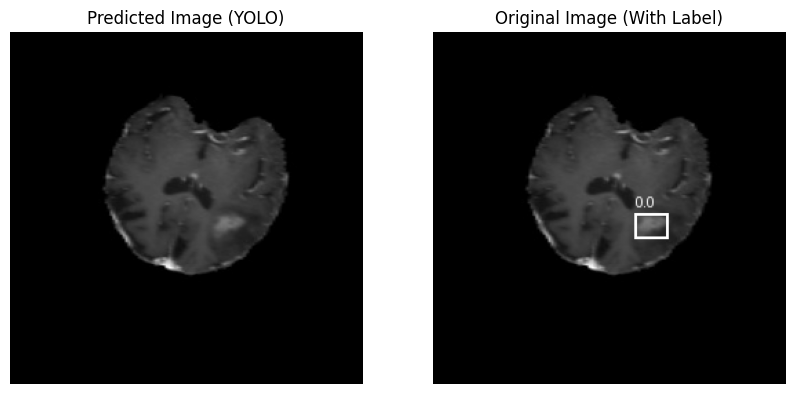

In [27]:
show_predicted_vs_real(index=50)

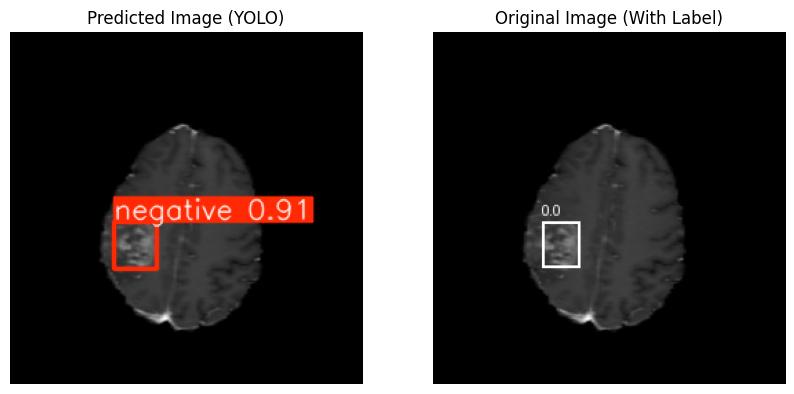

In [28]:
show_predicted_vs_real(index=60)